In [2]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
dataset = xr.open_dataset(r"C:\US-Baltimore_clean_observations_v1.nc", engine='netcdf4') #только для чтения
print(dataset)

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 43824)
Coordinates:
  * time         (time) datetime64[ns] 351kB 2002-01-01T05:00:00 ... 2007-01-...
Data variables: (12/30)
    SWdown       (time) float32 175kB ...
    LWdown       (time) float32 175kB ...
    Tair         (time) float32 175kB ...
    Qair         (time) float32 175kB ...
    PSurf        (time) float32 175kB ...
    Rainf        (time) float32 175kB ...
    ...           ...
    SWup_qc      (time) int8 44kB ...
    LWup_qc      (time) int8 44kB ...
    Qle_qc       (time) int8 44kB ...
    Qh_qc        (time) int8 44kB ...
    SoilTemp_qc  (time) int8 44kB ...
    Qtau_qc      (time) int8 44kB ...
Attributes: (12/24)
    title:                      Flux tower observations from US-Baltimore (af...
    summary:                    Quality controlled flux tower observations fo...
    sitename:                   US-Baltimore
    long_sitename:              Cub Hill, Baltimore, United States
    version:                

In [3]:
for var_name in ['Qh', 'Qle', 'Qtau']: 
    if var_name in dataset.data_vars:
        data = dataset[var_name]
        missing_count = np.isnan(data).sum().item()
        missing_pct = (missing_count / data.size)*100
        print (f"{var_name}: {missing_count}/{data.size} пропусков({missing_pct:.2f}%)")

Qh: 14336/43824 пропусков(32.71%)
Qle: 24166/43824 пропусков(55.14%)
Qtau: 7615/43824 пропусков(17.38%)


In [3]:
#статистика
for var in ['Qh', 'Qle', 'Qtau']:
    data = dataset[var]
    print(f"{var}:")
    print(f" среднее: {data.mean().item():.2f}")
    print(f" медиана: {np.nanmedian(data.values):.2f}")
    print(f" станд отклонение: {data.std().item():.2f}")
    print(f" мин: {data.min().item():.2f}")
    print(f" макс: {data.max().item():.2f}")

Qh:
 среднее: 36.88
 медиана: -0.60
 станд отклонение: 88.55
 мин: -110.82
 макс: 472.66
Qle:
 среднее: 45.62
 медиана: 17.69
 станд отклонение: 72.61
 мин: -158.73
 макс: 390.64
Qtau:
 среднее: 0.24
 медиана: 0.14
 станд отклонение: 0.30
 мин: 0.00
 макс: 3.28


In [4]:
# Убираем NaN только по Qh, Qle, Qtau
clean_ds = dataset[['Qh', 'Qle', 'Qtau']].dropna(dim='time', how='any')

# Объединяем с остальными переменными, но только по тем time, где Qh/Qle/Qtau валидны
full_ds = dataset.drop_vars(['Qh', 'Qle', 'Qtau'])

# Явно указываем join='left'
clean_ds = clean_ds.merge(full_ds, join='left')

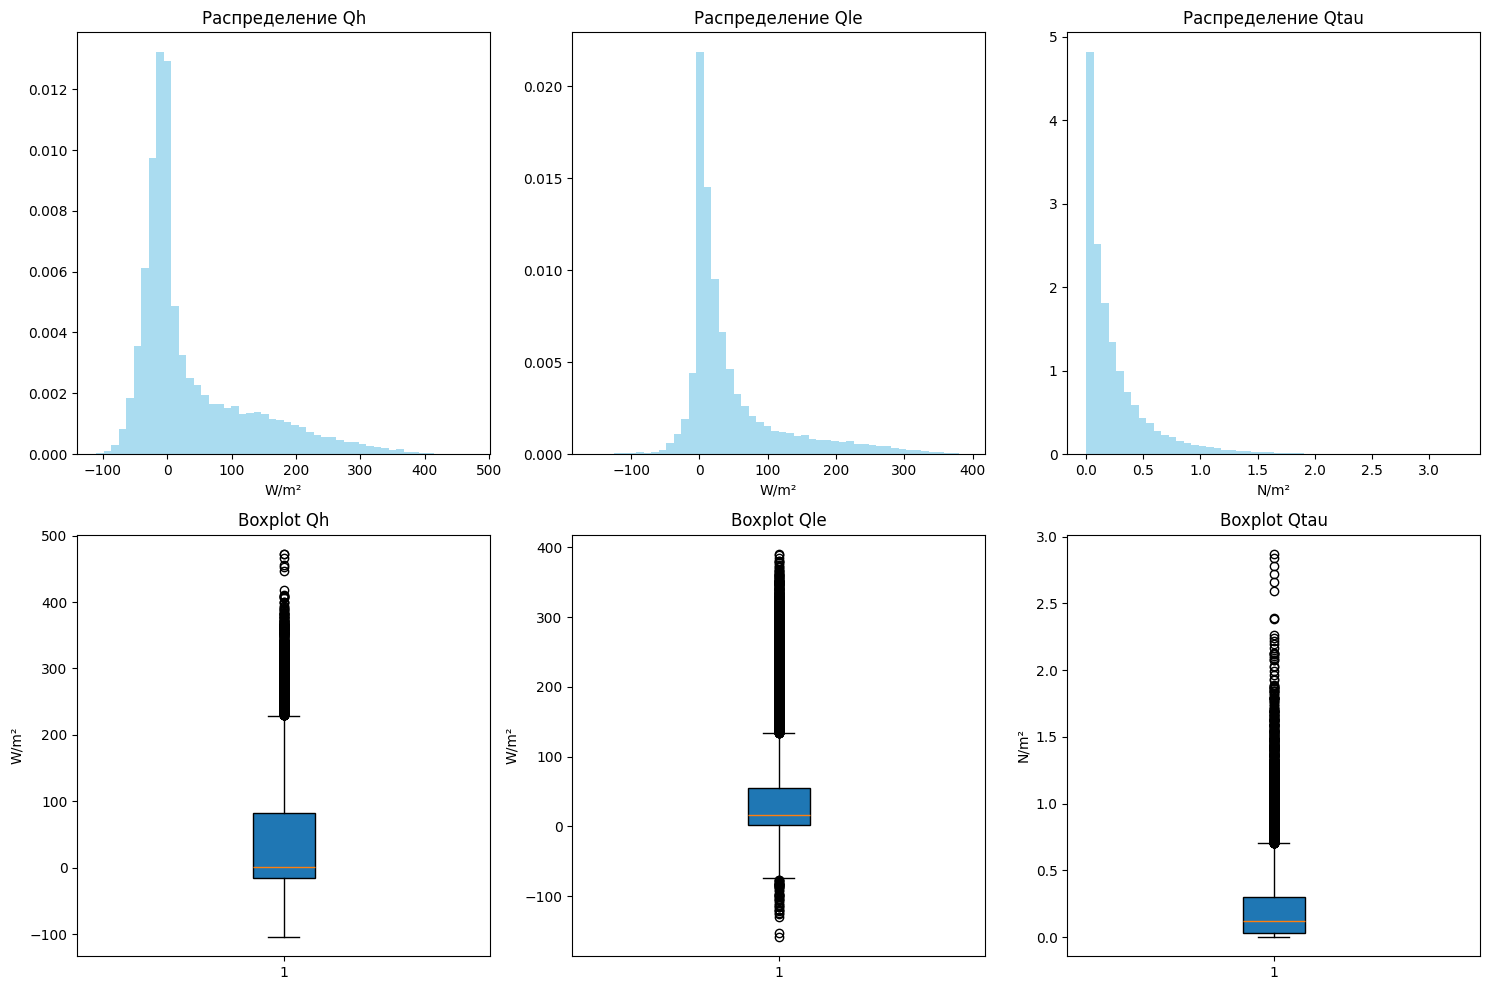

In [5]:
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # изменили на 2x3

# гистограммы распределений
variables = ['Qh', 'Qle', 'Qtau']  # убрали 'Wind_N', 'Wind_E'

for i, var in enumerate(variables):

    axes[0, i].hist(dataset[var].values, bins=50, alpha=0.7, density=True, color='skyblue')
    axes[0, i].set_title(f'Распределение {var}')
    

    if var in ['Qh', 'Qle']:
        axes[0, i].set_xlabel('W/m²')
    elif var == 'Qtau':
        axes[0, i].set_xlabel('N/m²')
    
    # Boxplot
    axes[1, i].boxplot(clean_ds[var].values, patch_artist=True)
    axes[1, i].set_title(f'Boxplot {var}')
    

    if var in ['Qh', 'Qle']:
        axes[1, i].set_ylabel('W/m²')
    elif var == 'Qtau':
        axes[1, i].set_ylabel('N/m²')

plt.tight_layout()
plt.show()

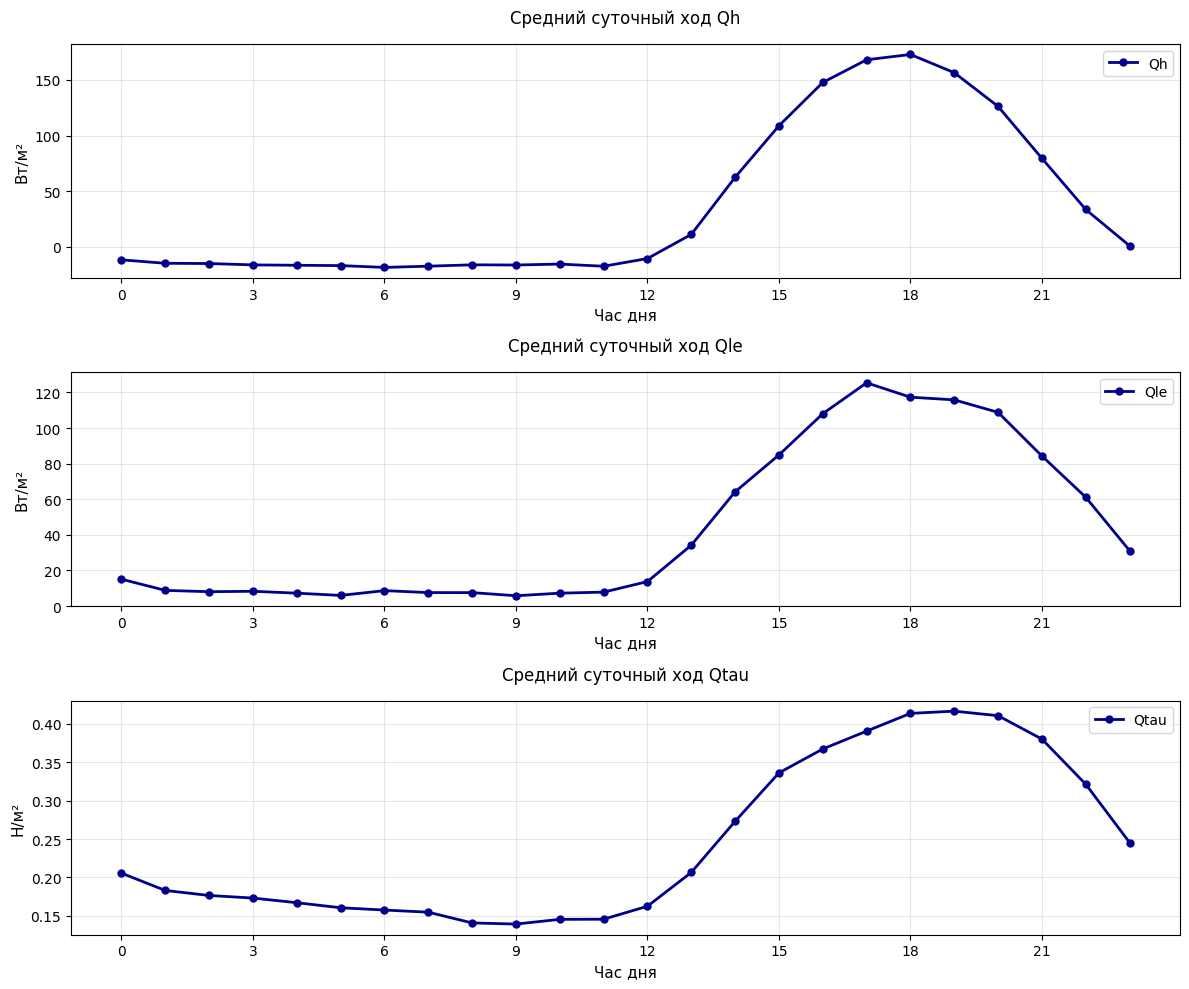

In [6]:
# --- Выбираем переменные ---
variables = ['Qh', 'Qle', 'Qtau']

# --- Создаём фигуру: 3 строки, 1 столбец ---
fig, axes = plt.subplots(3, 1, figsize=(12, 10))  # 3 вместо 5

for i, var in enumerate(variables):
    # --- Группируем по часам и берём среднее ---
    hourly_means = dataset[var].groupby('time.hour').mean(dim='time')
    
    # --- Строим график ---
    axes[i].plot(hourly_means.hour, hourly_means, 'o-', 
                 linewidth=2, markersize=5, color='darkblue', label=var)
    
    axes[i].set_title(f'Средний суточный ход {var}', fontsize=12, pad=15)
    axes[i].set_xlabel('Час дня', fontsize=11)
    axes[i].set_xticks(range(0, 24, 3))
    axes[i].grid(True, alpha=0.3)
    
    # --- Подпись оси Y ---
    if var in ['Qh', 'Qle']:
        axes[i].set_ylabel('Вт/м²', fontsize=11)
    elif var == 'Qtau':
        axes[i].set_ylabel('Н/м²', fontsize=11)
    
    # Опционально: добавить легенду
    axes[i].legend()

# --- Финальная компоновка ---
plt.tight_layout()
plt.show()

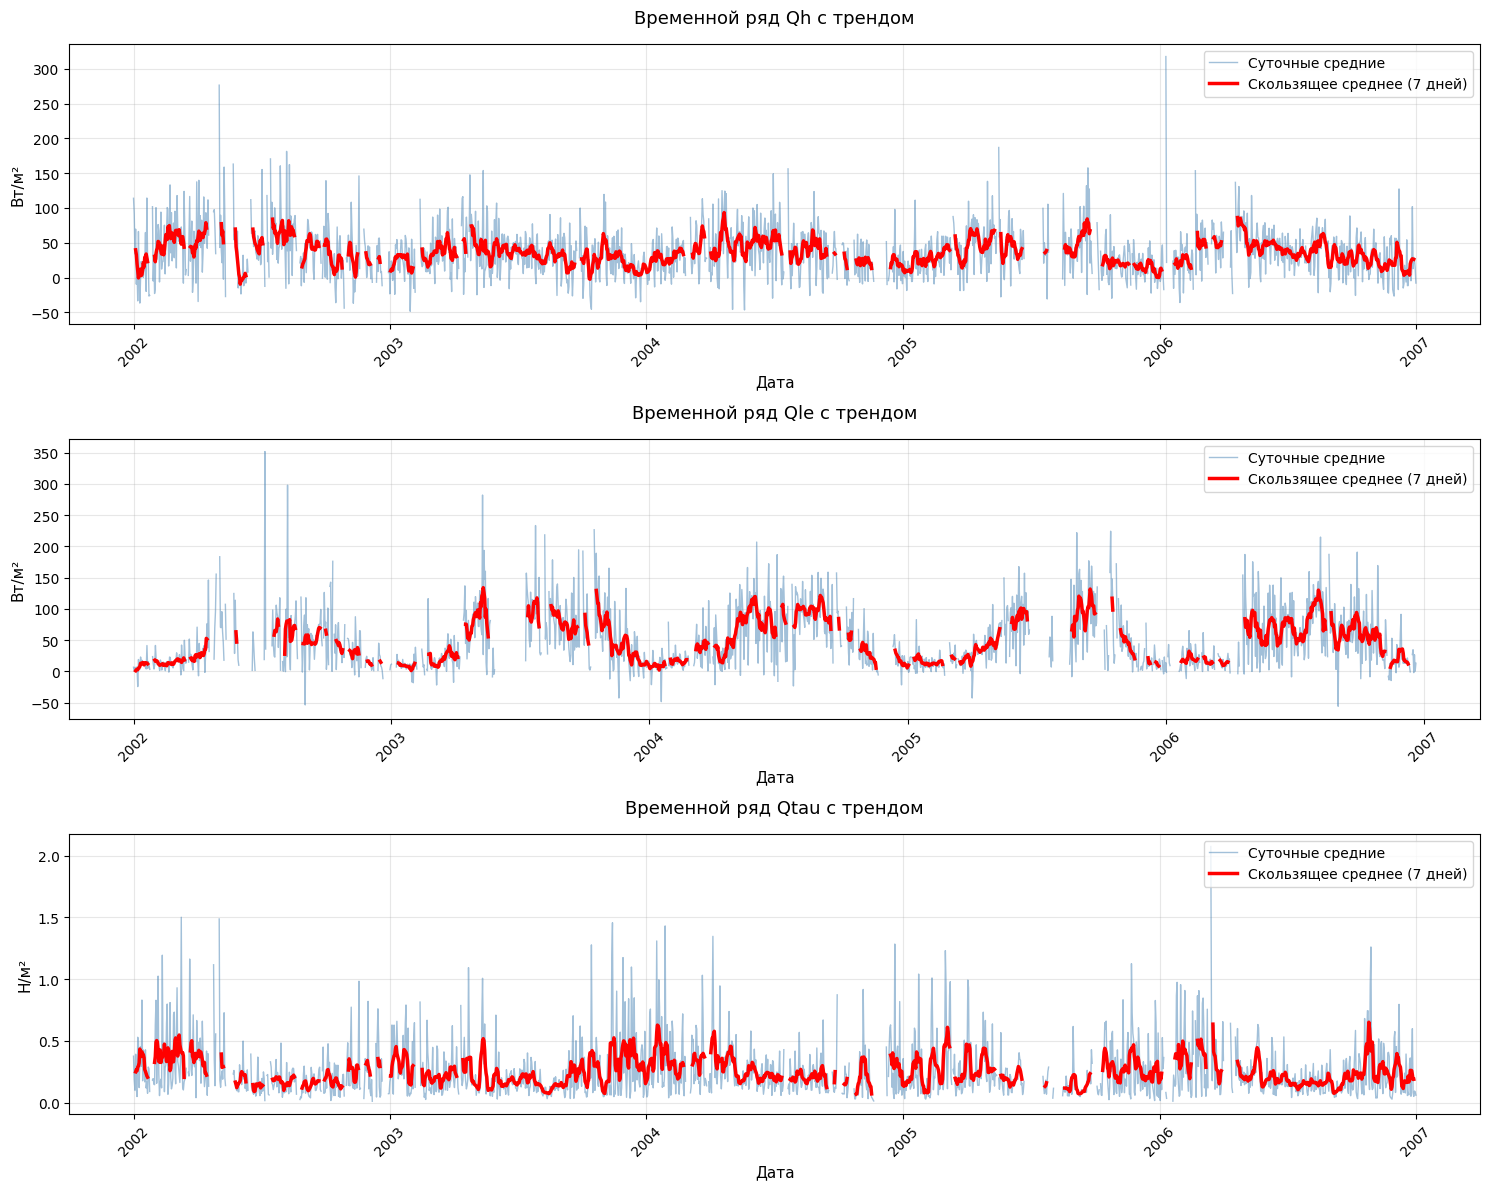

In [7]:
# --- Переменные для анализа ---
variables = ['Qh', 'Qle', 'Qtau']

# --- Фигура: 3 графика вертикально ---
fig, axes = plt.subplots(3, 1, figsize=(15, 12))  # 3 вместо 5

for i, var in enumerate(variables):
    data = dataset[var]  # xarray.DataArray

    # --- 1. Суточные средние ---
    daily_means = data.resample(time='1D').mean(skipna=True)

    # --- 2. Скользящее среднее за 7 дней (по суточным средним) ---
    weekly_avg = daily_means.rolling(time=7, center=True).mean()

    # --- 3. График ---
    # Суточные средние (полупрозрачные)
    axes[i].plot(daily_means.time, daily_means, 
                 alpha=0.5, label='Суточные средние', linewidth=1, color='steelblue')
    
    # Скользящее среднее (красная линия)
    axes[i].plot(weekly_avg.time, weekly_avg, 
                 linewidth=2.5, label='Скользящее среднее (7 дней)', color='red')

    # --- Подписи ---
    axes[i].set_title(f'Временной ряд {var} с трендом', fontsize=13, pad=15)
    axes[i].set_ylabel('Вт/м²' if var in ['Qh', 'Qle'] else 'Н/м²', fontsize=11)
    axes[i].set_xlabel('Дата', fontsize=11)
    
    # Легенда, сетка, метки
    axes[i].legend(fontsize=10, loc='upper right')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

# --- Финальная компоновка ---
plt.tight_layout()
plt.show()

АНАЛИЗ ДИСПЕРСИЙ И ИЗМЕНЧИВОСТИ:

Qh:
   Дисперсия:               7841.11
   Стандартное отклонение:  88.55
   Среднее:                 36.88
   Коэффициент вариации:    2.40
   Изменчивость:            высокая

Qle:
   Дисперсия:               5271.88
   Стандартное отклонение:  72.61
   Среднее:                 45.62
   Коэффициент вариации:    1.59
   Изменчивость:            высокая

Qtau:
   Дисперсия:               0.09
   Стандартное отклонение:  0.30
   Среднее:                 0.24
   Коэффициент вариации:    1.23
   Изменчивость:            высокая


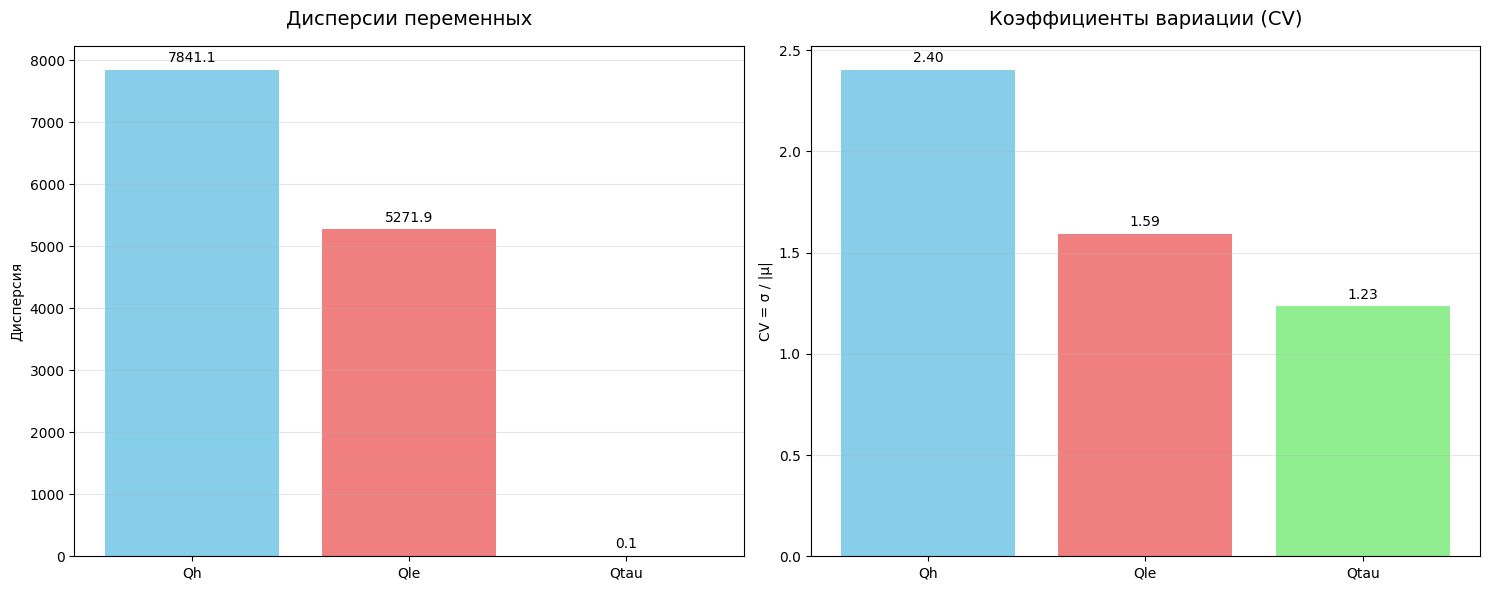


СЕЗОННАЯ ИЗМЕНЧИВОСТЬ (дисперсия по месяцам):
Qh: макс.дисперсия — Апр, мин.дисперсия — Дек
Qle: макс.дисперсия — Июл, мин.дисперсия — Янв
Qtau: макс.дисперсия — Фев, мин.дисперсия — Авг


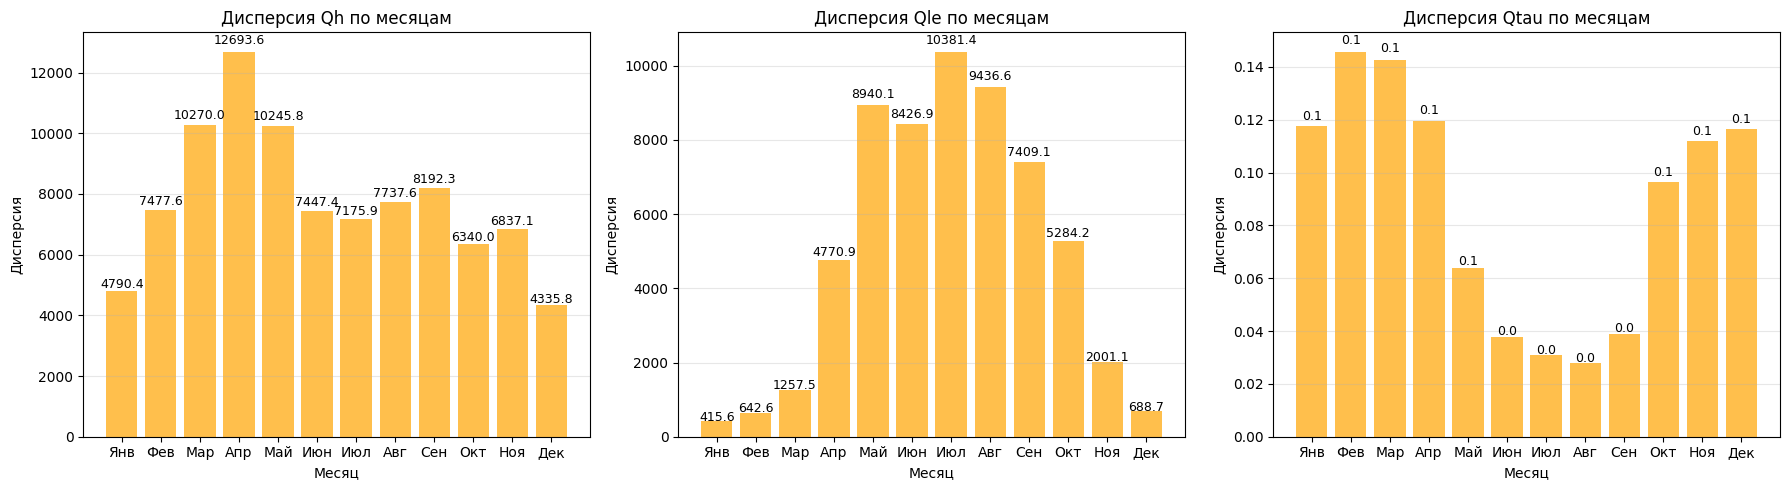

In [9]:
# -------------------------------------------------
#  АНАЛИЗ ДИСПЕРСИЙ И ИЗМЕНЧИВОСТИ
# -------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

print("АНАЛИЗ ДИСПЕРСИЙ И ИЗМЕНЧИВОСТИ:")
print("=" * 50)

variables = ['Qh', 'Qle', 'Qtau']  # Убраны Wind_N, Wind_E

# -------------------------------------------------
#  1. Общая статистика (по всему периоду)
# -------------------------------------------------
for var in variables:
    da = dataset[var]
    values = da.values
    clean = values[~np.isnan(values)]  # Убираем NaN

    variance = np.var(clean, ddof=0)
    std = np.std(clean, ddof=0)
    mean = np.mean(clean)
    cv = std / abs(mean) if mean != 0 else np.inf

    # Интерпретация
    if cv < 0.1:
        variability = "низкая"
    elif cv < 0.3:
        variability = "умеренная"
    else:
        variability = "высокая"

    print(f"\n{var}:")
    print(f"   Дисперсия:               {variance:.2f}")
    print(f"   Стандартное отклонение:  {std:.2f}")
    print(f"   Среднее:                 {mean:.2f}")
    print(f"   Коэффициент вариации:    {cv:.2f}")
    print(f"   Изменчивость:            {variability}")

# -------------------------------------------------
#  2. Визуализация: Дисперсия + CV
# -------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Дисперсии ---
variances = [np.var(dataset[v].values[~np.isnan(dataset[v].values)]) for v in variables]
bars1 = ax1.bar(variables, variances, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_title('Дисперсии переменных', fontsize=14, pad=15)
ax1.set_ylabel('Дисперсия')
ax1.grid(True, axis='y', alpha=0.3)
for bar, v in zip(bars1, variances):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(variances)*0.01,
             f'{v:.1f}', ha='center', va='bottom', fontsize=10)

# --- Коэффициенты вариации ---
cvs = []
for v in variables:
    clean = dataset[v].values[~np.isnan(dataset[v].values)]
    cv = np.std(clean) / abs(np.mean(clean)) if np.mean(clean) != 0 else np.inf
    cvs.append(cv)

bars2 = ax2.bar(variables, cvs, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Коэффициенты вариации (CV)', fontsize=14, pad=15)
ax2.set_ylabel('CV = σ / |μ|')
ax2.grid(True, axis='y', alpha=0.3)
for bar, cv in zip(bars2, cvs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cvs)*0.01,
             f'{cv:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# -------------------------------------------------
#  3. СЕЗОННАЯ ИЗМЕНЧИВОСТЬ: дисперсия по месяцам
# -------------------------------------------------
print("\nСЕЗОННАЯ ИЗМЕНЧИВОСТЬ (дисперсия по месяцам):")
print("=" * 55)

# Создаём 1x3 графика (было 2x3 → теперь 1x3)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()  # Для удобства

month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
               'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

for i, var in enumerate(variables):
    # Группируем по месяцам и считаем дисперсию (skipna=True)
    monthly_variance = dataset[var].groupby('time.month').var(skipna=True)

    # Строим столбчатую диаграмму
    bars = axes[i].bar(month_names, monthly_variance, color='orange', alpha=0.7)
    axes[i].set_title(f'Дисперсия {var} по месяцам', fontsize=12)
    axes[i].set_xlabel('Месяц')
    axes[i].set_ylabel('Дисперсия')
    axes[i].grid(True, axis='y', alpha=0.3)

    # Подписи значений
    for j, val in enumerate(monthly_variance):
        if not np.isnan(val):
            axes[i].text(j, val + val*0.02, f'{val:.1f}', ha='center', fontsize=9)

    # Статистика: месяцы с max/min дисперсией
    valid = monthly_variance.values[~np.isnan(monthly_variance.values)]
    if len(valid) > 0:
        max_idx = np.argmax(valid)
        min_idx = np.argmin(valid)
        max_month = month_names[max_idx]
        min_month = month_names[min_idx]
        print(f"{var}: макс.дисперсия — {max_month}, мин.дисперсия — {min_month}")

plt.tight_layout()
plt.show()